# Hypertension DDIs pipeline

Steps to build the pipeline:
1. Useful functions for the pipeline (mapping, retrieving data from web apis...)
2. Find positive and negative controls for the AE of interest
3. Retrieve adverse event report data for these and a set of control drugs
4. Build the training and testing frequency tables
5. Features reduction to avoid overfitting
6. Drugpair predictions
7. Corroboration using OHDSI data

In [1]:
import csv
import gzip
import tqdm
import json
import heapq
import random
import urllib2

import requests
import itertools

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats
from collections import defaultdict
from biothings_client import get_client

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from urllib2 import Request, urlopen, URLError, build_opener

#import OHDSI_API_data_ as ohdsi

%matplotlib inline

In [4]:
from import_notebook import *
sys.meta_path.append(NotebookFinder())
import OHDSI_API_data_ as ohdsi

## Needed functions

In [2]:
ADVERSE_EVENT_OF_INTEREST = 'hypertension'

# adverse events related to hypertension (from SIDER)
AE_LIST = ['hypertension', 'hypertention worsened', 'hypertension paroxysmal']

In [3]:
# Authentication module
# Instructions at https://documentation.uts.nlm.nih.gov/rest/home.html

#get the tgt corresponding to the apikey
def get_tgt(apikey):
    tgt = requests.post("https://utslogin.nlm.nih.gov/cas/v1/api-key", data = {'apikey':apikey})
    TGT = tgt.content.split()[20]
    TGT = TGT[52:+len(TGT)-1]
    return TGT

#get a ticket corresponding to the tgt
def get_ticket(tgt):
    uri_login = "https://utslogin.nlm.nih.gov/cas/v1/tickets/" + tgt
    ticket = requests.post(uri_login, data = {'service':'http://umlsks.nlm.nih.gov'})
    return ticket.content


In [4]:
def AEtoCUI(aeName):
    "Converts AE name to UMLS CUIs"
    cuis = []
    apikey = "6fd08e99-cb99-48be-937c-bbaa5205fd44"
    
    tgt = get_tgt(apikey)
    ticket = get_ticket(tgt)
    
    query = {'ticket':ticket}
    uri = "https://uts-ws.nlm.nih.gov/rest/search/current?string=" + aeName
    r = requests.get(uri, params = query)
    r.encoding = 'utf-8'
    items  = json.loads(r.text)
    
    jsonData = items["result"]
    for s in jsonData['results']:
        cuis.append(s['ui'])
    return cuis

In [5]:
def nsides_api(service, method, args = None):
    """
    Simple python API to access the NSIDES services and data.
    
    service   string, that can be one of three values: aeolus, sider, or omop
    method    string, for a list of methods see http://nsideseb-env.us-east-1.elasticbeanstalk.com
    args      dictionary, method parameters see http://nsideseb-env.us-east-1.elasticbeanstalk.com
    """
    NSIDES_API_URL = 'http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/'
    
    base_url = NSIDES_API_URL + 'query?service=%s&meta=%s' % (service, method)
    url = base_url
    if not args is None:
        url = base_url + '&' + '&'.join(['%s=%s' % (k,v) for k,v in args.items()])
    #print url
    
    response = urllib2.urlopen(url).read()
    data = json.loads(response)
    
    return data

# Test with one value
#reference_byname = list()
#data = nsides_api('sider', 'drugForEffect', {'q': 'C0235750'})
#reference_byname.extend( [(r['drug_name'], 1) for r in data['results']] )
#print len(reference_byname)
#print reference_byname

In [6]:
# map the name of a drug to its rxnorm notation
def annotator(text, ontologies):
    REST_URL = "http://data.bioontology.org"
    API_KEY = 'b55cf758-dbd3-4959-a9c0-2e6bba5b5d8b'
    url = REST_URL + "/annotator?text=" + urllib2.quote(text) + "&ontologies=" + ','.join(ontologies)
    opener = urllib2.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    
    annotations = json.loads(opener.open(url).read())

    return annotations

def name2rxnorm(drugname):
    annotations = annotator(drugname, ['RXNORM'])
    
    rxnorms = list()
    for annotation in annotations:
        rxnorms.append(annotations[0]['annotatedClass']['@id'].split('/')[-1])
    
    return rxnorms

print name2rxnorm('apraclonidine')

[u'14845']


In [7]:
def stitch_api(id):
    """
    Function to access STITCH data
    id : stitch id (string)
    returns drug rxnorm
    """
    STITCH_API_URL = 'http://stitch.embl.de/api/json/'
    request = 'resolve?identifier=%s' %(id)
    
    url = STITCH_API_URL + request
    
    response = urllib2.urlopen(url).read()
    data = json.loads(response)
    
    return data
    
data = stitch_api('CID000041774')
print data[0]['preferredName']
print name2rxnorm('acarbose')

acarbose
[u'16681']


## Find positive and negative controls

In [8]:
# Write the cuis corresponding to hypertension in a csv file
f = "cuis_hypertension.csv"
ff = open(f,'w')

for cui in AEtoCUI("hypertension"):
    ff.write(cui)
    ff.write("\n")
    #print cui
    
ff.close()

#print len(AEtoCUI("hypertension"))

In [9]:
# Get a list of drugs (name) known to have hypertension as a side effect using SIDER
reference_byname = list()
for cui in AEtoCUI('hypertension'):
    #print cui
    if cui=='C0020538' : #this cui causes a 500 error
        continue
    else :
        data = nsides_api('sider', 'drugForEffect', {'q': "%s" %cui})
        reference_byname.extend( [(r['drug_name'], 1) for r in data['results']] )
    
if len(reference_byname) == 0:
    raise Exception("No available reference standard for cui: %s" % cui)

reference_byname = sorted(set(reference_byname))
print len(reference_byname)
#print sorted(reference_byname)

84


In [10]:
# We map those drugs to their rxnorm
positives = list()
negatives = list()

drugnames = [d for d,e in reference_byname]
#print drugnames

#we write the positive controls in a csv file
c = csv.writer(open("positive_controls.csv", "wb"))

for drugname, causes_ae in tqdm(reference_byname):
    
    rxnorms = name2rxnorm(drugname)
    
    for rxnorm in rxnorms:
        if causes_ae == 1:
            positives.append(int(rxnorm))
            c.writerow([int(rxnorm)])
            
        else:
            negatives.append(int(rxnorm))

print "Produced reference with %d positive examples and %d negative examples." % (len(positives), len(negatives))

100%|██████████| 84/84 [00:41<00:00,  1.81it/s]

Produced reference with 80 positive examples and 0 negative examples.


In [11]:
# If there are no negative examples, we randomly pick 200 from what's available in AEOLUS
if len(negatives) == 0:
    data = nsides_api('aeolus', 'ingredientList')
    
    c = csv.writer(open("negative_controls.csv", "wb"))
    
    all_rxnorms = [r['concept_code'] for r in data['results']]
    available_negatives = (set(all_rxnorms) - set(positives))
    
    negatives = random.sample(available_negatives, 200)
    #negatives = available_negatives
    
    for rxnorm in negatives:
        c.writerow([int(rxnorm)])

print "Randomly selected %d negative examples from available drugs." % len(negatives)
#print negatives

Randomly selected 200 negative examples from available drugs.


##  Retrieve adverse event report data for these and a set of control drugs.

In [12]:
# concept = OMOP concept id
data = nsides_api('aeolus', 'ingredientList')

concept2name = dict()
all_drugs = list()
drug_mapping = dict()
concept2rxnorm = dict()
rxnorm2concept = dict()

for r in data['results']:
    concept2name[r['concept_id']] = r['concept_name']
    all_drugs.append(r['concept_id'])
    drug_mapping[r['concept_code']] = r['concept_id']
    concept2rxnorm[r['concept_id']] = r['concept_code']
    rxnorm2concept[r['concept_code']] = r['concept_id']

#print drug_mapping.items()
#print concept2name
print data['results'][0]
print len(all_drugs)
#print concept2rxnorm[501343]
print rxnorm2concept[5640]

{u'valid_end_date': u'2099-12-31', u'concept_class_id': u'Ingredient', u'valid_start_date': u'1970-01-01', u'vocabulary_id': u'RxNorm', u'concept_name': u'hepatitis B immune globulin', u'invalid_reason': u'', u'standard_concept_id': 501343, u'standard_concept': u'S', u'concept_code': 26744, u'domain_id': u'Drug', u'concept_id': 501343}
3526
1177480


In [13]:
#query?service=aeolus&meta=reactionListMedDRA
data = nsides_api('aeolus', 'reactionListMedDRA')

# List of all AEs reported in FAERS
all_outcomes = list() 

for r in data['results']:
    all_outcomes.append(r['outcome_concept_id'])

print len(all_outcomes)
print data['results'][0]
print all_outcomes[0]

7540
{u'valid_end_date': u'2099-12-31', u'concept_class_id': u'LLT', u'outcome_concept_id': 36718526, u'valid_start_date': u'1970-01-01', u'vocabulary_id': u'MedDRA', u'concept_name': u'Convulsion', u'invalid_reason': u'', u'snomed_outcome_concept_id': 377091, u'standard_concept': u'C', u'concept_code': 10010904, u'domain_id': u'Condition', u'concept_id': 36718526}
36718526


In [14]:
#query?service=aeolus&meta=drugpairReactionListMedDRA
data = nsides_api('aeolus', 'drugpairReactionListMedDRA')
#List of all AEs reported as drugpairs outcome in FAERS
all_pairoutcomes = list()
all_conceptnames = list()
for r in data['results']:
    all_pairoutcomes.append(r['outcome_concept_id'])
    all_conceptnames.append(r['concept_name'])

print len(all_pairoutcomes)
print all_pairoutcomes[0]
print data['results'][0]

#for r in all_conceptnames:
#    print r

199
37622529
{u'valid_end_date': u'2099-12-31', u'concept_class_id': u'PT', u'outcome_concept_id': 37622529, u'valid_start_date': u'1970-01-01', u'vocabulary_id': u'MedDRA', u'concept_name': u'Hypertension', u'invalid_reason': u'', u'standard_concept': u'C', u'concept_code': 10020772, u'domain_id': u'Condition', u'concept_id': 37622529}


In [15]:
#query?service=aeolus&meta=drugpairList
data = nsides_api('aeolus', 'drugpairList')

all_drugpairs = list()

for r in data['results']:
    all_drugpairs.append((r['drug1_concept_id'], r['drug2_concept_id']))

print len(all_drugpairs)
print all_drugpairs[0]

39800
(19111620, 19122121)


In [16]:
#query?service=aeolus&meta=drugReactionCounts&q=0
data = nsides_api('aeolus', 'drugReactionCounts', {'q':0})

aeolus_drugReactionCounts = dict()
aeolus_drugReactionCounts['results'] = list()

for start in tqdm(range(0, data[0]['nrows'][0], 10000)):    
    aeolus_drugReactionCounts['results'].extend(data[0]['result'])    
    start = len(aeolus_drugReactionCounts['results'])
    data = nsides_api('aeolus', 'drugReactionCounts', {'q': start})

print len(aeolus_drugReactionCounts['results'])

100%|██████████| 64/64 [03:13<00:00,  2.99s/it]

631743


In [17]:
print aeolus_drugReactionCounts['results'][0]
print aeolus_drugReactionCounts['results'][1]

{u'nreports': 11, u'outcome_concept_id': 35104067, u'drug_concept_id': 904453, u'ndrugreports': 448710}
{u'nreports': 13, u'outcome_concept_id': 35104067, u'drug_concept_id': 1112807, u'ndrugreports': 1077453}


In [18]:
unrecognized_id = list()
unrecognized_id.append('CID011953896')
unrecognized_id.append('CID000003706')
unrecognized_id.append('CID000002550')
unrecognized_id.append('CID000031371')
unrecognized_id.append('CID000054688')
unrecognized_id.append('CID000000653')
unrecognized_id.append('CID000009908')
unrecognized_id.append('CID000005257')
unrecognized_id.append('CID000006691')
unrecognized_id.append('CID000002177')
unrecognized_id.append('CID000002949')
unrecognized_id.append('CID000002909')
unrecognized_id.append('CID000005267')
unrecognized_id.append('CID000028112')
unrecognized_id.append('CID000001451')
unrecognized_id.append('CID000016213')
unrecognized_id.append('CID000003075')
unrecognized_id.append('CID005311048')
unrecognized_id.append('CID000003929')
unrecognized_id.append('CID000004691')
unrecognized_id.append('CID000003962')
unrecognized_id.append('CID005361912')
unrecognized_id.append('CID000005064')
unrecognized_id.append('CID006420046')
unrecognized_id.append('CID000003143')
unrecognized_id.append('CID000004048')
unrecognized_id.append('CID000003222')
unrecognized_id.append('CID000150310')
unrecognized_id.append('CID000005372')
unrecognized_id.append('CID000062924')
unrecognized_id.append('CID000443871')
unrecognized_id.append('CID006419754')
unrecognized_id.append('CID000004547')
unrecognized_id.append('CID000065027')
unrecognized_id.append('CID000004259')
unrecognized_id.append('CID011953892')
unrecognized_id.append('CID000004724')
unrecognized_id.append('CID000002769')
unrecognized_id.append('CID000005412')

print len(unrecognized_id)

39


In [19]:
#query?service=va&meta=get_ddi_alerts

# Retrieve data from the Veteran Affairs Hospital (Stitch ids)
# We map those drugs to their rxnorm

data = nsides_api('va', 'get_ddi_alerts')
print data['results'][0]
print len(data['results'])

va_ddi_alerts = list()

for r in tqdm(data['results']):
    
    #print r
    
    if (r['drug_1'] in unrecognized_id) or (r['drug_2'] in unrecognized_id):
        continue
    
    stitch_data1 = stitch_api(r['drug_1'])
    stitch_data2 = stitch_api(r['drug_2'])

    drugs1 = name2rxnorm(stitch_data1[0]['preferredName'])
    drugs2 = name2rxnorm(stitch_data2[0]['preferredName'])
    
    for drug1 in drugs1:
        drug1 = (int(drug1))
    for drug2 in drugs2:
        drug2 = (int(drug2))
        
    va_ddi_alerts.append((drug1, drug2))

print len(va_ddi_alerts)
print va_ddi_alerts[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

{u'interaction': 1, u'drug_1': u'CID000041774', u'drug_2': u'CID000005379'}
1000


100%|██████████| 1000/1000 [26:17<00:00,  2.06s/it]

641
(16681, 228476)


In [20]:
key_errors = list()
key_errors.append(17941)
key_errors.append(7930)
key_errors.append(357280)
key_errors.append(218863)
key_errors.append(353062)

In [21]:
# We map drugpairs from rxnorm to their OMOP id
va_omop_ddi = list()

for drugpair in va_ddi_alerts:
    #print drugpair
    if drugpair[0] in key_errors:
        continue
    if drugpair[1] in key_errors:
        continue
    va_omop_ddi.append((rxnorm2concept[drugpair[0]],rxnorm2concept[drugpair[1]]))

print len(va_ddi_alerts)
print len(va_omop_ddi)
print va_omop_ddi[0]

641
574
(1529331, 1789276)


In [22]:
#LOINC to OMOP
#/api/v1/query?service=omop&meta=get_omop_from_loinc&q=28377-0
data = nsides_api('omop', 'get_omop_from_loinc', {'q':'28377-0'})
print len(data)
print data

1
{u'results': [{u'concept_id': u'3000000'}]}


## Build the training table for single drugs

In [23]:
def make_lsd_training_table(pos_drugs = None, neg_drugs = None):

    # we map positive and negative drugs from their concept_code to their concept_id
    pos_drugs_mapped = list()
    for pos_drug in pos_drugs:
        pos_drugs_mapped.append(drug_mapping[pos_drug])
        
    neg_drugs_mapped = list()
    for neg_drug in neg_drugs:
        neg_drugs_mapped.append(drug_mapping[neg_drug])
        
    outcomes = np.concatenate((np.ones(len(pos_drugs),np.bool), np.zeros(len(neg_drugs),np.bool)))
    
    training_drugs = pos_drugs_mapped + neg_drugs_mapped
    
    # build the adverse events frequency table
    ae_frequencies_training = np.zeros((len(pos_drugs)+len(neg_drugs),len(all_pairoutcomes)))
    
    for r in aeolus_drugReactionCounts['results']:
        if not r['drug_concept_id'] in training_drugs:
            continue
        if not r['outcome_concept_id'] in all_pairoutcomes:
            continue
        
        
        i = training_drugs.index(r['drug_concept_id'])
        j = all_pairoutcomes.index(r['outcome_concept_id'])
        
        frequency = float(r['nreports'])/float(r['ndrugreports'])
        
        ae_frequencies_training[i,j] = frequency
                    
    return ae_frequencies_training, outcomes

In [24]:
# we only keep drugs that can be mapped
pos_controls = [p for p in positives if p in drug_mapping]
neg_controls = [n for n in negatives if n in drug_mapping]

print len(pos_controls)
print len(neg_controls)

72
200


In [25]:
X,y = make_lsd_training_table(pos_controls, neg_controls)

print X.shape
print y.shape

print y.sum()

(272, 199)
(272,)
72


### Same process for drugpairs

In [26]:
#query?service=aeolus&meta=drugpairReactionCounts&q=0
data = nsides_api('aeolus', 'drugpairReactionCounts', {'q':0})

aeolus_drugpairReactionCounts = dict()
aeolus_drugpairReactionCounts['results'] = list()

for start in tqdm(range(0, data[0]['nrows'][0], 10000)):    
    aeolus_drugpairReactionCounts['results'].extend(data[0]['results'])    
    start = len(aeolus_drugpairReactionCounts['results'])
    data = nsides_api('aeolus', 'drugpairReactionCounts', {'q': start})

len(aeolus_drugpairReactionCounts['results'])

100%|██████████| 793/793 [09:13<00:00,  1.85it/s]


1313184

In [27]:
aeolus_drugpairReactionCounts['results'][0]

{u'drug1_concept_id': 19111620,
 u'drug2_concept_id': 19122121,
 u'n_d1d2': 722,
 u'n_d1d2ae': 38,
 u'outcome_concept_id': 37622529}

In [28]:
# build the frequency table for drugpairs
def make_lsd_testing_table():
    ae_frequencies_ddi_testing = np.zeros((len(all_drugpairs),len(all_pairoutcomes)))
    
    for r in tqdm(aeolus_drugpairReactionCounts['results']):
        
        drugpair = (r['drug1_concept_id'],r['drug2_concept_id'])
        if r['outcome_concept_id'] in all_pairoutcomes:
            x_index = all_drugpairs.index(drugpair)
            y_index = all_pairoutcomes.index(r['outcome_concept_id'])
            
            frequency = float(r['n_d1d2ae'])/float(r['n_d1d2'])
            
            ae_frequencies_ddi_testing[x_index,y_index] = frequency    
                
    return ae_frequencies_ddi_testing

In [29]:
X_test = make_lsd_testing_table()

100%|██████████| 1313184/1313184 [16:51<00:00, 1297.97it/s]


In [37]:
print X.shape #Dimension of the ae frequencies training table
print X_test.shape #Dimension of the ae frequencies ddi testing table
print y.shape #Number of outcomes (positive + negative controls)

#print len(aeolus_drugpairReactionCounts['results'])

print np.sum(y)

X_test.sum(), X_test.mean()

(272, 199)
(39800, 199)
(272,)
72


(72613.835694147696, 0.009168182077996476)

## Features reduction (to avoid overfitting)

In [38]:
#Need to reduce the number of features: 199 features is too much compared to 'only' 272 examples (i.e pos+neg controls)
#Method: L1 (lasso) regularization + 10 fold cross-validation

In [39]:
# Features reduction using L1 regularization + 10-folds cross-validation

def l1_regression(X, y, alpha, predictions):
    l1 = Lasso(alpha=alpha,fit_intercept=True, max_iter=100000, tol=0.0001)
    l1.fit(X,y)
    y_pred = l1.predict(X)
    coef = l1.coef_
    
    auc_score = roc_auc_score(y, y_pred)
    print 'auc score: %f' %auc_score
    predictions.append([(pred, label) for label,pred in zip(y, y_pred)])
    
    nb_coef = 0
    for i in range (0, len(coef)):
        if coef[i] != 0.:
            nb_coef+=1
    print "Number of coef with alpha = %f: %d" %(alpha,nb_coef)
    #print "l1 intercept: %f " %l1.intercept_
    return coef, auc_score   

In [40]:
# We build 6 different potential fingerprint (with a different number of features each time)
alphas = [0.00009, 1e-4, 0.0002, 0.0003, 0.0004, 0.0006, 0.0007]

coef_lasso= np.zeros((len(alphas),len(all_pairoutcomes)))
predictions = list()

for i in range (0, len(alphas)):
    coef, auc_score = l1_regression(X, y, alphas[i], predictions)
    for j in range(0,len(all_pairoutcomes)):
        coef_lasso[i][j] = coef[j] 

auc score: 0.928264
Number of coef with alpha = 0.000090: 23
auc score: 0.921319
Number of coef with alpha = 0.000100: 22
auc score: 0.895660
Number of coef with alpha = 0.000200: 13
auc score: 0.876493
Number of coef with alpha = 0.000300: 13
auc score: 0.848576
Number of coef with alpha = 0.000400: 9
auc score: 0.828785
Number of coef with alpha = 0.000600: 7
auc score: 0.827500
Number of coef with alpha = 0.000700: 6


In [46]:
#print coef_lasso[2]

[ 0.70434783  0.80116959  0.9125      0.78055556  0.73043478]
[ 0.89473684  0.91875     0.9047619   0.88695652  0.875     ]
[ 0.91875     0.9826087   0.83625731  0.79679144  0.9125    ]
[ 0.76023392  0.84210526  0.91666667  0.85714286  0.83957219]
[ 0.75        0.84795322  0.82312925  0.684375    0.87878788]
[ 0.78911565  0.74561404  0.8128655   0.66666667  0.91875   ]
[ 0.86394558  0.85964912  0.82051282  0.8707483   0.78888889]
[ 0.78580155  0.89604105  0.88938149  0.84314418  0.79684907  0.78660237
  0.84074894]


(9e-05, 0.0007)

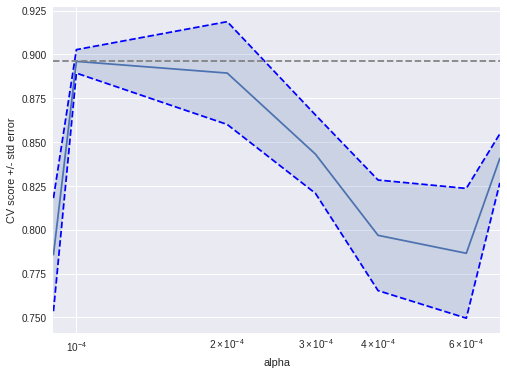

In [41]:
# We use 10-fold cross-validation to evaluate the models
alphas = [0.00009, 1e-4, 0.0002, 0.0003, 0.0004, 0.0006, 0.0007] #we get between 5 and 19 features using these values of alpha
n_folds = 5
scores = list()
scores_std = list()

for alpha in alphas:
    lasso = Lasso(alpha=alpha,fit_intercept=True, max_iter=100000, tol=0.0001)
    lasso_fit = lasso.fit(X,y)
    #print y.sum()
    #print len(y)
    cv = ShuffleSplit(n_splits=n_folds)
    this_scores = cross_val_score(lasso_fit, X, y, scoring='roc_auc', cv=cv, n_jobs=1)
    print this_scores
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)
print scores

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

######  Selection of alpha depending on the validation score
Depending on the way the test group is picked, we have different values of alpha. 
So we test the model with three different values of alpha: [0.0001, 0.0002, 0.0003]

In [42]:
# Extract the set of relevant features and their weight, alpha = 0.0002
features_indice = list()
features_weight = list()
features = list()

for i in range (len(coef_lasso[1])):
    if coef_lasso[1][i] != 0.:
        features_indice.append(i)

print len(features_indice)

for i in range (len(all_pairoutcomes)):
    if i in features_indice:
        features.append(all_pairoutcomes[i])
        features_weight.append((all_pairoutcomes[i], coef_lasso[1][i]))
    
print len(features)
print len(features_weight)
print features[0]

22
22
22
37622529


In [43]:
# Build the new frequency tables
def make_lsd_training_table_reduced(features, pos_drugs = None, neg_drugs = None):

    # we map positive and negative drugs from their concept_code to their concept_id
    pos_drugs_mapped = list()
    for pos_drug in pos_drugs:
        pos_drugs_mapped.append(drug_mapping[pos_drug])
        
    neg_drugs_mapped = list()
    for neg_drug in neg_drugs:
        neg_drugs_mapped.append(drug_mapping[neg_drug])
        
    outcomes = np.concatenate((np.ones(len(pos_drugs),np.bool), np.zeros(len(neg_drugs),np.bool)))
    
    training_drugs = pos_drugs_mapped + neg_drugs_mapped
    
    # build the adverse events frequency table
    ae_frequencies_training = np.zeros((len(pos_drugs)+len(neg_drugs),len(features)))
    
    for r in aeolus_drugReactionCounts['results']:
        if not r['drug_concept_id'] in training_drugs:
            continue
        if not r['outcome_concept_id'] in features:
            continue
        
        
        i = training_drugs.index(r['drug_concept_id'])
        j = features.index(r['outcome_concept_id'])
        
        frequency = float(r['nreports'])/float(r['ndrugreports'])
        
        ae_frequencies_training[i,j] = frequency
                    
    return ae_frequencies_training, outcomes


# Build the frequency table for drugpairs
def make_lsd_testing_table_reduced(features):
    ae_frequencies_ddi_testing = np.zeros((len(all_drugpairs),len(features)))
    
    for r in tqdm(aeolus_drugpairReactionCounts['results']):
        
        drugpair = (r['drug1_concept_id'],r['drug2_concept_id'])
        if r['outcome_concept_id'] in features:
            x_index = all_drugpairs.index(drugpair)
            y_index = features.index(r['outcome_concept_id'])
            
            frequency = float(r['n_d1d2ae'])/float(r['n_d1d2'])
            #print frequency
            
            ae_frequencies_ddi_testing[x_index,y_index] = frequency    
                
    return ae_frequencies_ddi_testing

In [44]:
X_reduced, y_reduced = make_lsd_training_table_reduced(features, pos_controls, neg_controls)

print X_reduced.shape
print y_reduced.shape

(272, 22)
(272,)


In [45]:
X_test_reduced = make_lsd_testing_table_reduced(features)

100%|██████████| 1313184/1313184 [03:53<00:00, 5614.85it/s] 


In [46]:
print features[0]
print X_test_reduced.shape
#print X_test_reduced[2]

37622529
(39800, 22)


## Build the latent signal detection model (i.e hypertension's fingerprint)

In [47]:
# We use a Logistic Regression Binary classifier: each drug or drug pair is represented by a combination of AEs and their weight (beta coefficient)
# If a drug is above a certain threshold, we classify it as causing hypertension

def score(features_weight, X_test):
    score = list()
    
    for drugpair in X_test:
        #print drugpair
        drugpair_score = 0
        for i in range (0, len(features)):
            drugpair_score += drugpair[i] * features_weight[i][1]
        score.append(drugpair_score)
    
    return score

def y_pred_FAERS(drug_mapping):
    
    y_pred = np.zeros((len(scores)))
    pos_drugs_mapped = list()
    
    for pos_drug in pos_controls:
        if pos_drug not in drug_mapping:
            continue
        
    pos_drugs_mapped.append(drug_mapping[pos_drug])
    
    # if a drugpair has a drug known to be a positive control then we predict that the drugpair will lead to the AE
    for drugpair in all_drugpairs:         
        for drug in drugpair:
            if drug in pos_drugs_mapped:
                y_pred[all_drugpairs.index(drugpair)] = 1
                
    return y_pred

def y_pred_va():
    
    y_pred = np.zeros((len(scores)))
    
    # if a drugpair has a drug known to be a positive control then we predict that the drugpair will lead to the AE
    for drugpair in all_drugpairs:         
        if drugpair in va_omop_ddi :
            y_pred[all_drugpairs.index(drugpair)] = 1
    
    return y_pred

def predict_ddi(scores, threshold):
    
    predictions = np.zeros((len(scores)))
    for score in scores:
        if (score > threshold):
            predictions[scores.index(score)] = 1
    print sum(predictions)
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    y_pred_VA = y_pred_va()
    
    print "Number of positive predictions from FAERS:",np.sum(y_pred_Faers)
    print "Number of positive predictions from the VA:",np.sum(y_pred_VA)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=scores)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=scores)
    
    print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=scores)
    fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=scores)
    
    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predictions
            

39800
4.42349750526
5159.0
Number of positive predictions from FAERS: 398.0
Number of positive predictions from the VA: 14.0
FAERS drugpairs ROC: 0.737106041858
VA drugpairs ROC: 0.606175180071


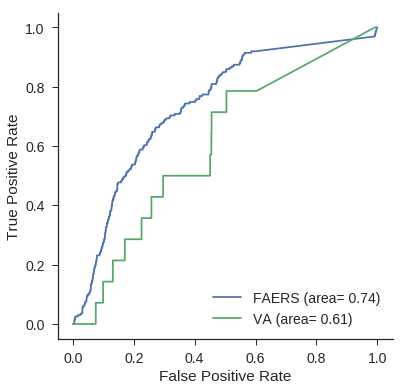

In [48]:
scores = score(features_weight, X_test_reduced)
print len(scores)
print scores[0]

threshold = 5
predictions = predict_ddi(scores, threshold)

  1%|          | 11938/1313184 [00:00<00:10, 119378.98it/s]

0.0001
10


100%|██████████| 1313184/1313184 [01:49<00:00, 12032.30it/s]


(39800, 10)
5591.0


  0%|          | 0/1313184 [00:00<?, ?it/s]

Number of positive predictions from FAERS: 398.0
Number of positive predictions from the VA: 14.0
FAERS drugpairs ROC: 0.733398860706
VA drugpairs ROC: 0.569460901538
0.0002
9


100%|██████████| 1313184/1313184 [01:58<00:00, 11052.17it/s]


(39800, 9)
3967.0


  0%|          | 0/1313184 [00:00<?, ?it/s]

Number of positive predictions from FAERS: 398.0
Number of positive predictions from the VA: 14.0
FAERS drugpairs ROC: 0.728481757042
VA drugpairs ROC: 0.55855972309
0.0003
8


100%|██████████| 1313184/1313184 [01:56<00:00, 11226.62it/s]


(39800, 8)
2525.0
Number of positive predictions from FAERS: 398.0
Number of positive predictions from the VA: 14.0
FAERS drugpairs ROC: 0.718124657091
VA drugpairs ROC: 0.552218655521


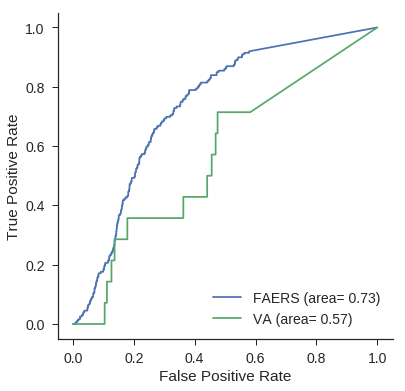

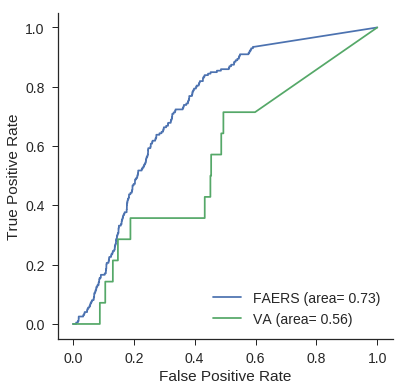

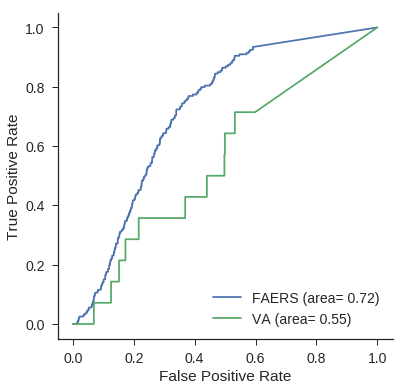

In [47]:
# Loop to test all three models
# We use a Logistic Regression Binary classifier: each drug or drug pair is represented by a combination of AEs and their weight (beta coefficient)
# If a drug is above a certain threshold, we classify it as causing hypertension

alphas_selected = [0.0001, 0.0002, 0.0003]
threshold = 4

for alpha in alphas_selected:
    print alpha
    
    #Extraction of features
    features_indice = list()
    features_weight = list()
    features = list()

    for i in range (len(coef_lasso[2+alphas_selected.index(alpha)])):
        if coef_lasso[2+alphas_selected.index(alpha)][i] != 0.:
            features_indice.append(i)

    for i in range (len(all_pairoutcomes)):
        if i in features_indice:
            features.append(all_pairoutcomes[i])
            features_weight.append((all_pairoutcomes[i], coef_lasso[2+alphas_selected.index(alpha)][i]))
    
    print len(features)
    
    #Construction of the new testing frequency table
    X_test_reduced = make_lsd_testing_table_reduced(features)
    print X_test_reduced.shape
    
    #Fingerprint construction
    scores = score(features_weight, X_test_reduced)
    predictions = predict_ddi(scores, threshold)


In [49]:
# Random Forest Classifier after the L1 reduction of features

def drugpair_predictions_reduced(X, y, X_test):
    
    # can't use oob after L1 regularization
    rf = RandomForestClassifier(n_estimators = 100, oob_score=False, random_state=12)
    rf.fit(X,y) #Build a forest of trees from the training set (X, y).
    
    predictions_proba = rf.predict_proba(X_test)[:,1]
    predictions = rf.predict(X_test) #predict class for X_test
    print "Mean accuracy on the given test data and labels: ", rf.score(X,y)  
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    y_pred_VA = y_pred_va()
    
    predicted_ddi = sorted(zip(predictions_proba, all_drugpairs))
    predicted_ddi.reverse()
    i=0
    while predicted_ddi[i][0]>0.5:
        i+=1
    predicted_ddi = predicted_ddi[:i]
            
    #(i.e with at least one drug known to have hypertension as a side effect)
    print "Number of positive predictions:",np.sum(y_pred_Faers)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=predictions_proba)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=predictions_proba)
    
    print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=predictions_proba)
    fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=predictions_proba)

    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predicted_ddi

Mean accuracy on the given test data and labels:  0.996323529412
Number of positive predictions: 398.0
FAERS drugpairs ROC: 0.707681726229
VA drugpairs ROC: 0.620909365103
15906


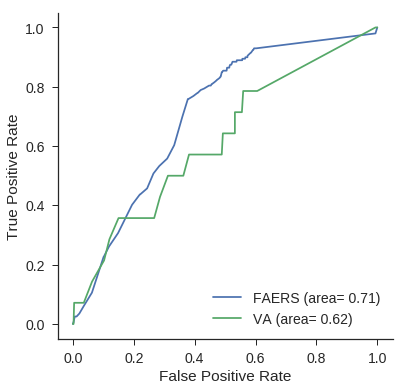

In [50]:
predicted_ddi = drugpair_predictions_reduced(X_reduced,y_reduced,X_test_reduced)
print len(predicted_ddi)

In [55]:
def drugpair_predictions(X,y,X_test):  
    
    rf = RandomForestClassifier(n_estimators = 100, oob_score=True, random_state=12)
    rf.fit(X,y) #Build a forest of trees from the training set (X, y).
    
    print "Number of estimators: ", len(rf.estimators_)
    
    predictions_proba = rf.predict_proba(X_test)[:,1]
    predictions = rf.predict(X_test) #predict class for X_test
    print "Mean accuracy on the given test data and labels: ", rf.score(X,y)   

    oob_predictions = rf.oob_decision_function_[:,1]
    oob_predictions[ np.where( np.isnan(oob_predictions) == True)[0]] = 0
    
    #roc_auc_score computes the area under the ROC curve
    print "OOB ROC:",roc_auc_score(y_true=y, y_score=oob_predictions)
    fprOOB, tprOOB, _ = roc_curve(y_true=y,y_score=oob_predictions)
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    y_pred_VA = y_pred_va()
    
    predicted_ddi = sorted(zip(predictions_proba, all_drugpairs))
    predicted_ddi.reverse()
    i=0
    while predicted_ddi[i][0]>0.5:
        i+=1
    predicted_ddi = predicted_ddi[:i]
            
    #(i.e with at least one drug known to have hypertension as a side effect)
    print "Number of positive predictions FAERS:",np.sum(y_pred_Faers)
    print "Number of ddi predictions (with a probability > 0,5): ", len(predicted_ddi)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=predictions_proba)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=predictions_proba)
    
    print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=predictions_proba)
    fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=predictions_proba)
    
    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprOOB,tprOOB,label='OOB (area= %0.2f)' % auc(fprOOB,tprOOB))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predicted_ddi

Number of estimators:  100
Mean accuracy on the given test data and labels:  0.996323529412
OOB ROC: 0.865625
Number of positive predictions FAERS: 398.0
Number of ddi predictions (with a probability > 0,5):  12290
FAERS drugpairs ROC: 0.662355480769
VA drugpairs ROC: 0.562279624563


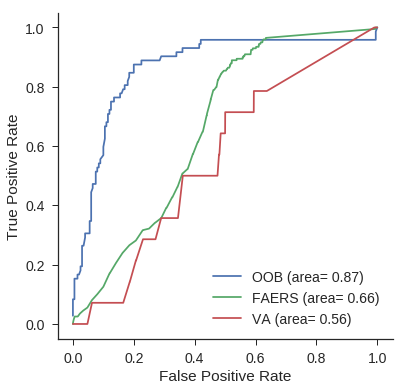

In [56]:
pred_ddi = drugpair_predictions(X,y,X_test)

## DDI predictions

In [50]:
c = csv.writer(open("top_ddi.csv", "wb"))
for prob, ddi in predicted_ddi:
    c.writerow([prob, ddi])

In [48]:
#Treatment of the predictions
final_predictions = list()

pos_drugs_mapped = list()
for pos_drug in pos_controls:
    if pos_drug not in drug_mapping:
        continue
        
    pos_drugs_mapped.append(drug_mapping[pos_drug])

# Removing the pairs where at least one of the drugs is known to be responsible for hypertension alone
for prob, drugpair in predicted_ddi:
    if (drugpair[0] not in pos_drugs_mapped):
        if (drugpair[1] not in pos_drugs_mapped):
            # All drugpairs are twice in the list ((a,b) and (b,a)), we only keep one
            if drugpair[0] > drugpair[1]:
                final_predictions.append(drugpair)

print len(predicted_ddi)
print len(final_predictions)                
top_ddi = final_predictions[:50]
#print top_ddi

17652
6152


In [52]:
c = csv.writer(open("top_ddi_treated.csv", "wb"))
for ddi in final_predictions:
    c.writerow([ddi])

In [49]:
# Pull the top prediction
pair = top_ddi[0]
pair2 = top_ddi[1]
print pair
print pair2
print concept2name[pair[0]], concept2name[pair[1]]
print concept2name[pair2[0]], concept2name[pair2[1]]

(19135832, 1597756)
(19135832, 1351557)
Multivitamin preparation glimepiride
Multivitamin preparation candesartan


## Corroborate drugpair predictions using OHDSI data
Analysis of the top 50 predicted DDIs.
Method: Creation of cohorts of patients using the OHDSI API.
Criteria: Patients exposed to either drug of a predicted drugpair alone and patients exposed to both within a 30 days interval.
All patients must have had their blood pressure measured within 30 days of their last drug intake. 

In [67]:
# Retrieve patient information for the top 50 ddi predictions

In [68]:
# Assess significance of the difference in values of BP for drugpair and control groups using Mann-Whitney U test
from scipy.stats import mannwhitneyu

In [69]:
# Correct for multiple hypothesis testing using Bonferroni's method